# Linear Regression Model

Given the stock prices for the last `N` days, we train a model, and predict the price for day `N+1`

In [3]:
import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import time

from datetime import date, datetime, time, timedelta
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from tqdm import tqdm_notebook

## Data Collection

In [4]:
import pandas_datareader.data as web
import yfinance as yf
import datetime

def data_collection(ticker, start, end):
    
    df = web.get_data_yahoo(ticker, start, end)
    
    # Convert Date column to datetime
    #df['Date'] = df.index
    #df.loc[:, 'Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

    # Change all column headings to be lower case, and remove spacing
    df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

    # Get month of each sample
    #df['month'] = df['date'].dt.month
    
    return df

/Users/little/opt/anaconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [5]:
# Load Data
df = data_collection('AAPL', datetime.date(2010,1,1), datetime.date.today())
df.head()

,high,low,open,close,volume,adj_close
Date,,,,,,
2010-01-04,30.642857,30.340000,30.490000,30.572857,123432400.0,26.538483
2010-01-05,30.798571,30.464285,30.657143,30.625713,150476200.0,26.584366
2010-01-06,30.747143,30.107143,30.625713,30.138571,138040000.0,26.161509
2010-01-07,30.285715,29.864286,30.250000,30.082857,119282800.0,26.113146
2010-01-08,30.285715,29.865715,30.042856,30.282858,111902700.0,26.286753


In [30]:
# Split train & test
train = data_collection('AMZN', datetime.date(2010,1,1), datetime.date(2017,12,31))
test = data_collection('AMZN', datetime.date(2018,1,1), datetime.date.today())

display(train.head())
display(test.head())

,high,low,open,close,volume,adj_close
Date,,,,,,
2010-01-04,136.610001,133.139999,136.250000,133.899994,7599900,133.899994
2010-01-05,135.479996,131.809998,133.429993,134.690002,8851900,134.690002
2010-01-06,134.729996,131.649994,134.600006,132.250000,7178800,132.250000
2010-01-07,132.320007,128.800003,132.009995,130.000000,11030200,130.000000
2010-01-08,133.679993,129.029999,130.559998,133.520004,9830500,133.520004


,high,low,open,close,volume,adj_close
Date,,,,,,
2018-01-02,1190.000000,1170.510010,1172.000000,1189.010010,2694500,1189.010010
2018-01-03,1205.489990,1188.300049,1188.300049,1204.199951,3108800,1204.199951
2018-01-04,1215.869995,1204.660034,1205.000000,1209.589966,3022100,1209.589966
2018-01-05,1229.140015,1210.000000,1217.510010,1229.140015,3544700,1229.140015
2018-01-08,1253.079956,1232.030029,1236.000000,1246.869995,4279500,1246.869995


## Prediction

In [17]:
X_train = train.drop('close', axis=1)
X_train

,high,low,open,volume,adj_close
Date,,,,,
2010-01-04,136.610001,133.139999,136.250000,7599900,133.899994
2010-01-05,135.479996,131.809998,133.429993,8851900,134.690002
2010-01-06,134.729996,131.649994,134.600006,7178800,132.250000
2010-01-07,132.320007,128.800003,132.009995,11030200,130.000000
2010-01-08,133.679993,129.029999,130.559998,9830500,133.520004
...,...,...,...,...,...
2017-12-22,1174.619995,1167.829956,1172.079956,1585100,1168.359985
2017-12-26,1178.319946,1160.550049,1168.359985,2005200,1176.760010
2017-12-27,1187.290039,1175.609985,1179.910034,1867200,1182.260010


In [116]:
train.tail(6)

,high,low,open,close,volume,adj_close
Date,,,,,,
2017-12-21,1179.170044,1167.640015,1175.900024,1174.760010,2123100,1174.760010
2017-12-22,1174.619995,1167.829956,1172.079956,1168.359985,1585100,1168.359985
2017-12-26,1178.319946,1160.550049,1168.359985,1176.760010,2005200,1176.760010
2017-12-27,1187.290039,1175.609985,1179.910034,1182.260010,1867200,1182.260010
2017-12-28,1190.099976,1184.380005,1189.000000,1186.099976,1841700,1186.099976
2017-12-29,1184.000000,1167.500000,1182.349976,1169.469971,2688400,1169.469971


In [7]:
Y_train = np.array(train['close'][len(train) - 5 : len(df)]).reshape(-1, 1)
Y_train

array([[1168.35998535],
       [1176.76000977],
       [1182.26000977],
       [1186.09997559],
       [1169.4699707 ]])

In [140]:
# Train the model
reg = LinearRegression(fit_intercept = True)
reg.fit(X_train, Y_train)        

print(reg.intercept_)
print(reg.coef_)

[1210.03901214]
[[ 5.75435213e+00 -2.25067715e-05]]


In [132]:
X_train = np.array(range(len(df['close'][0 : 5]))).reshape(-1, 1)
X_train

array([[0],
       [1],
       [2],
       [3],
       [4]])

In [138]:
# Predict the `N+1` day stock price
pred1 = reg.predict(np.array(5).reshape(1,-1))
print(pred1)

[[1180.05797119]]


### X_train: 0, volume

In [139]:
X_train = np.array([[0, 1585100], [1, 2005200], [2,1867200], [3,1841700], [4,2688400]])
X_train

array([[      0, 1585100],
       [      1, 2005200],
       [      2, 1867200],
       [      3, 1841700],
       [      4, 2688400]])

In [141]:
# Predict the `N+1` day stock price with volume
pred2 = reg.predict(np.array([[5, 2688400]]).reshape(1,-1))
print(pred2)

[[1178.30356835]]


### X_train: drop 'close'

In [31]:
X_train = np.array(df.drop('close', axis = 1)[0:10])
X_train

array([[1.36610001e+02, 1.33139999e+02, 1.36250000e+02, 7.59990000e+06,
        1.33899994e+02],
       [1.35479996e+02, 1.31809998e+02, 1.33429993e+02, 8.85190000e+06,
        1.34690002e+02],
       [1.34729996e+02, 1.31649994e+02, 1.34600006e+02, 7.17880000e+06,
        1.32250000e+02],
       [1.32320007e+02, 1.28800003e+02, 1.32009995e+02, 1.10302000e+07,
        1.30000000e+02],
       [1.33679993e+02, 1.29029999e+02, 1.30559998e+02, 9.83050000e+06,
        1.33520004e+02],
       [1.32800003e+02, 1.29210007e+02, 1.32619995e+02, 8.77940000e+06,
        1.30309998e+02],
       [1.29820007e+02, 1.26550003e+02, 1.28990005e+02, 9.09630000e+06,
        1.27349998e+02],
       [1.29710007e+02, 1.25750000e+02, 1.27900002e+02, 1.07232000e+07,
        1.29110001e+02],
       [1.30380005e+02, 1.26400002e+02, 1.29139999e+02, 9.77490000e+06,
        1.27349998e+02],
       [1.29649994e+02, 1.27059998e+02, 1.29179993e+02, 1.53765000e+07,
        1.27139999e+02]])

In [34]:
Y_train = np.array(df['close'][0:10]).reshape(-1, 1)
Y_train

array([[133.8999939 ],
       [134.69000244],
       [132.25      ],
       [130.        ],
       [133.52000427],
       [130.30999756],
       [127.34999847],
       [129.11000061],
       [127.34999847],
       [127.13999939]])

In [35]:
df.head(11)

,high,low,open,close,volume,adj_close
Date,,,,,,
2010-01-04,136.610001,133.139999,136.250000,133.899994,7599900,133.899994
2010-01-05,135.479996,131.809998,133.429993,134.690002,8851900,134.690002
2010-01-06,134.729996,131.649994,134.600006,132.250000,7178800,132.250000
2010-01-07,132.320007,128.800003,132.009995,130.000000,11030200,130.000000
2010-01-08,133.679993,129.029999,130.559998,133.520004,9830500,133.520004
2010-01-11,132.800003,129.210007,132.619995,130.309998,8779400,130.309998
2010-01-12,129.820007,126.550003,128.990005,127.349998,9096300,127.349998
2010-01-13,129.710007,125.750000,127.900002,129.110001,10723200,129.110001
2010-01-14,130.380005,126.400002,129.139999,127.349998,9774900,127.349998


In [36]:
# Train the model
reg = LinearRegression(fit_intercept = True)
reg.fit(X_train, Y_train)        

print(reg.intercept_)
print(reg.coef_)

[-3.22586402e-11]
[[-1.37789932e-15  6.09208489e-16  4.13413066e-16  3.27901988e-18
   1.00000000e+00]]


In [37]:
df.drop('close', axis = 1).iloc[10]

high         1.280000e+02
low          1.243300e+02
open         1.263100e+02
volume       8.892600e+06
adj_close    1.276100e+02
Name: 2010-01-19 00:00:00, dtype: float64

In [38]:
# Predict the `N+1` day stock price
pred3 = reg.predict(np.array(df.drop('close', axis = 1).iloc[10]).reshape(1,-1))
print(pred3)

[[127.61000061]]


In [68]:
np.std(Y_train)

2.731545129132505

In [19]:
pred3 + np.std(Y_train)

array([[131.91995815]])

In [21]:
num_train = len(train)
num_train

2013

In [22]:
num_test = len(test)
num_test

553

In [23]:
range(num_train, len(df['close']))

range(2013, 2566)

In [26]:
range(len(df['close']))

range(0, 2566)

### Function: Moving Linear Regression

In [1]:
def linear_prediction(df, target_col, N, pred_min, offset):
    """
    Given a dataframe of stock price, get prediction at timestep t using values from t-1, t-2, ..., t-N.
    Inputs
        df         : dataframe with the values you want to predict
        target_col : name of the column you want to predict e.g. 'close'
        N          : get prediction at timestep t using values from t-1, t-2, ..., t-N
        pred_min   : all predictions should be >= pred_min, e.g. '0'
        offset     : for df we only do predictions for df[offset:]. e.g. offset can be size of training set
    Outputs
        pred_list  : the predictions for target_col. np.array of length len(df)-offset.
    """
    
    # Define a regressor
    reg = LinearRegression(fit_intercept = True)

    # Create a prediction list
    pred_list = []

    for i in range(offset, len(df[target_col])):
        # Defind the training set
        X_train = np.array(range(len(df[target_col][i-N : i]))) # e.g. [0 1 2 3 4]
        X_train = X_train.reshape(-1, 1) # transfor the data dimension
        Y_train = np.array(df[target_col][i-N : i]) # e.g.[30.5728569 , 30.62571335, 30.13857079, 30.08285713, 30.28285789]
        Y_train = Y_train.reshape(-1, 1)
        
        # Train the model
        reg.fit(X_train, Y_train)        
        
        # Predict the `N+1` day stock price
        pred = reg.predict(np.array(N).reshape(1,-1))
        
        # Add the predicted result to the list
        pred_list.append(pred[0][0])
        
    # If the values are < pred_min, set it to be pred_min
    pred_list = np.array(pred_list)
    pred_list[pred_list < pred_min] = pred_min
        
    return pred_list    

In [39]:
df.head()

,high,low,open,close,volume,adj_close
Date,,,,,,
2010-01-04,136.610001,133.139999,136.250000,133.899994,7599900,133.899994
2010-01-05,135.479996,131.809998,133.429993,134.690002,8851900,134.690002
2010-01-06,134.729996,131.649994,134.600006,132.250000,7178800,132.250000
2010-01-07,132.320007,128.800003,132.009995,130.000000,11030200,130.000000
2010-01-08,133.679993,129.029999,130.559998,133.520004,9830500,133.520004


In [128]:
target_col = 'close'
N = 30
pred_min = 0

In [129]:
len(df)

71

In [130]:
range(N, len(df[target_col]))

range(30, 71)

In [131]:
reg = LinearRegression(fit_intercept = True)


pred_list = []
one_std = []
    
for i in range(N, len(df[target_col])):
    X = np.array(df.drop(target_col, axis = 1)[i-N : i])
    Y = np.array(df[target_col][i-N : i]).reshape(-1, 1)
        
    # Train the model
    reg.fit(X, Y)   
        
    # Predict the `N+1` day stock price
    pred = reg.predict(np.array(df.drop(target_col, axis = 1).iloc[i]).reshape(1,-1))   
        
    # Add the predicted result and first standard deviation to the list
    pred_list.append(pred[0][0])
    one_std.append(np.std(Y))
    
    
# If the values are < pred_min, set it to be pred_min
pred_list = np.array(pred_list)
pred_list[pred_list < pred_min] = pred_min

In [108]:
len(df)
len(df_pred)
len(one_std)

543

In [133]:
df_pred = df.iloc[N:]
df_pred.loc[:, 'Prediction'] = pred_list
df_pred.loc[:, 'Upper'] = pred_list + one_std
df_pred.loc[:, 'Lower'] = pred_list - one_std
df_pred.head()

,high,low,open,close,volume,adj_close,Prediction,Upper,Lower
Date,,,,,,,,,
2020-01-15,315.500000,309.549988,311.850006,311.339996,30480900.0,310.602844,311.340004,327.405585,295.274424
2020-01-16,315.700012,312.089996,313.589996,315.239990,27207300.0,314.493591,315.239973,331.477927,299.002018
2020-01-17,318.739990,315.000000,316.269989,318.730011,34454100.0,317.975372,318.730020,334.927746,302.532294
2020-01-21,319.019989,316.000000,317.190002,316.570007,27710800.0,315.820465,316.570000,332.844889,300.295111
2020-01-22,319.989990,317.309998,318.579987,317.700012,25458100.0,316.947815,317.700027,333.943538,301.456516


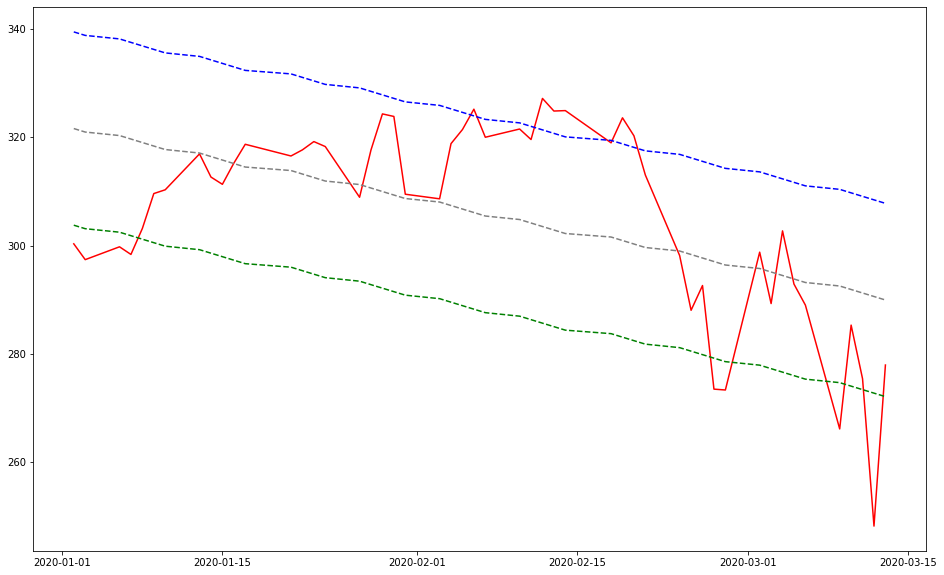

In [169]:
fig = plt.figure(figsize=(16,10))

plt.plot(df_pred[['close']], color = 'red')
plt.plot(df_pred[['Prediction']], color = 'gray', linestyle='dashed')
plt.plot(df_pred[['Upper']], color = 'blue', linestyle='dashed')
plt.plot(df_pred[['Lower']], color = 'green',linestyle='dashed')

In [ ]:
def linear_prediction(df, target_col, N):
    
    pred_list = []
    first_sd = []
    
    for i in range(len(df[target_col])):
        X = np.array(df.drop(target_col, axis = 1)[0+i : 10+i])
        Y = np.array(df[target_col][0+i: 10+i]).reshape(-1, 1)
    
    

In [ ]:
def linear_prediction(df, target_col, N, pred_min, offset):
    """
    Given a dataframe of stock price, get prediction at timestep t using values from t-1, t-2, ..., t-N.
    Inputs
        df         : dataframe with the values you want to predict
        target_col : name of the column you want to predict e.g. 'close'
        N          : get prediction at timestep t using values from t-1, t-2, ..., t-N
        pred_min   : all predictions should be >= pred_min, e.g. '0'
        offset     : for df we only do predictions for df[offset:]. e.g. offset can be size of training set
    Outputs
        pred_list  : the predictions for target_col. np.array of length len(df)-offset.
    """
    
    # Define a regressor
    reg = LinearRegression(fit_intercept = True)

    # Create a prediction list
    pred_list = []

    for i in range(len(df[target_col])):
                
        # Defind the training set
        X_train = np.array(range(len(df[target_col][i-N : i]))) # e.g. [0 1 2 3 4]
        X_train = X_train.reshape(-1, 1) # transfor the data dimension
        Y_train = np.array(df[target_col][i-N : i]) # e.g.[30.5728569 , 30.62571335, 30.13857079, 30.08285713, 30.28285789]
        Y_train = Y_train.reshape(-1, 1)
        
        # Train the model
        reg.fit(X_train, Y_train)        
        
        # Predict the `N+1` day stock price
        pred = reg.predict(np.array(N).reshape(1,-1))
        
        # Add the predicted result to the list
        pred_list.append(pred[0][0])
        
    # If the values are < pred_min, set it to be pred_min
    pred_list = np.array(pred_list)
    pred_list[pred_list < pred_min] = pred_min
        
    return pred_list    

### Function: Prediction from past 30 days

In [495]:
# Load Data
df = data_collection('AAPL', datetime.date(2019,8,1), datetime.date(2019,10,1))
df.head()

,high,low,open,close,volume,adj_close
Date,,,,,,
2019-08-01,218.029999,206.740005,213.899994,208.429993,54017900.0,206.529373
2019-08-02,206.429993,201.630005,205.529999,204.020004,40862100.0,202.159607
2019-08-05,198.649994,192.580002,197.990005,193.339996,52393000.0,191.576981
2019-08-06,198.070007,194.039993,196.309998,197.000000,35824800.0,195.203613
2019-08-07,199.559998,193.820007,195.410004,199.039993,33364400.0,197.225006


In [309]:
target_col = 'close'
pred_min = 0

In [310]:
target_col = 'close'

X = np.array(range(len(df[target_col]))).reshape(-1, 1)
Y = np.array(df[target_col]).reshape(-1, 1)

In [311]:
len(Y)

22

In [312]:
model = LinearRegression(fit_intercept = True)

# Train the model
model.fit(X, Y)        
 
print("Slope:", model.coef_)
print("Intercept:", model.intercept_)


Slope: [[0.41048586]]
Intercept: [200.64762607]


In [316]:
# If deviation closer to 0, it is more risky
one_std = np.std(Y)
deviation = 0.7

pred_list = model.predict(X)
df_pred = df
df_pred.loc[:, 'Prediction'] = pred_list
df_pred.loc[:, 'Upper'] = pred_list + one_std*deviation
df_pred.loc[:, 'Lower'] = pred_list - one_std*deviation
df_pred

,high,low,open,close,volume,adj_close,Prediction,Upper,Lower
Date,,,,,,,,,
2019-08-01,218.029999,206.740005,213.899994,208.429993,54017900.0,206.529373,200.647626,204.086825,197.208427
2019-08-02,206.429993,201.630005,205.529999,204.020004,40862100.0,202.159607,201.058112,204.497311,197.618913
2019-08-05,198.649994,192.580002,197.990005,193.339996,52393000.0,191.576981,201.468598,204.907797,198.029399
2019-08-06,198.070007,194.039993,196.309998,197.000000,35824800.0,195.203613,201.879084,205.318283,198.439885
2019-08-07,199.559998,193.820007,195.410004,199.039993,33364400.0,197.225006,202.289570,205.728768,198.850371
2019-08-08,203.529999,199.389999,200.199997,203.429993,27009500.0,201.574982,202.700055,206.139254,199.260856
2019-08-09,202.759995,199.289993,201.300003,200.990005,24619700.0,199.913925,203.110541,206.549740,199.671342
2019-08-12,202.050003,199.149994,199.619995,200.479996,22474900.0,199.406647,203.521027,206.960226,200.081828
2019-08-13,212.139999,200.479996,201.020004,208.970001,47218500.0,207.851212,203.931513,207.370712,200.492314
